In [1]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
from torch.distributions import MultivariateNormal
import pandas as pd

# I use the work of Eric Yu to help me build this algorithm. Link: https://github.com/ericyangyu/PPO-for-Beginners

In [2]:
#2) Set up Neural Network functions and classes

class Model_PPO(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
    """  
    def __init__(self, np_inputs, nb_outputs):
        super(Model_PPO, self).__init__()   
        self.layer1 = nn.Linear(np_inputs, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, nb_outputs)
        torch.nn.init.uniform_(self.layer3.weight,0.003, 0.006)

    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        activation1 = F.relu(self.layer1(input1))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

In [3]:
#3) Rollout on the environment:

class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def reset(self):
        """
        Reset: reinitilization (lists et environment).
        """
        self.prev_state = env.reset()
        self.batch_obs=[]
        self.batch_acts=[]
        self.batch_log_probs=[]
        self.batch_rews = []
    
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch
        """
        for ep in range(nbr_episodes):
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(action.dim()==0):
                        action=torch.unsqueeze(action,dim=0)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    #action_all=np.append(action_all,np.argmax(action[1:4].detach().numpy()))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action_all)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float)
    
    def iterations_rand(self,actor_net, cov_mat, batch_size):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param cov_mat: covariance matrix used for exploration
        :param batch_size: batch size
        :return: Tensors; state batch, action batch, log_proba batch
        """
        t = 0
        while t<batch_size:
            ep_rews = []
            prev_state = self.env.reset()
            for step_ep in range(self.max_steps): 
                t += 1
                with torch.no_grad():
                    parameters_based = torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(prev_state), dim=0).float()))
                    if(parameters_based.dim()==0):
                        parameters_based=torch.unsqueeze(parameters_based,dim=0)
                    distribution_p = MultivariateNormal(parameters_based, cov_mat)
                    action = distribution_p.sample()
                    log_proba = distribution_p.log_prob(action)
                    action_all=np.array([])
                    action_all=np.append(action_all,np.clip(action[0].detach().numpy(), -1.0, 1.0))
                    state, reward, done, _ = self.env.step(action_all)
                    self.batch_obs.append(prev_state)
                    self.batch_acts.append(action.detach().numpy())
                    self.batch_log_probs.append(log_proba)
                    ep_rews.append(reward)
                    prev_state = state
                if done:
                    break
            self.batch_rews.append(ep_rews)
        return torch.tensor(self.batch_obs, dtype=torch.float), torch.tensor(self.batch_acts, dtype=torch.float), torch.tensor(self.batch_log_probs, dtype=torch.float)

    def immediate_rewards(self):
        """
        Immediate rewards
        :return: Tensor; batch reward
        """
        batch_rewards = []
        for ep_rews in self.batch_rews:
            for rew in reversed(ep_rews):
                batch_rewards.insert(0,rew)
        return torch.tensor(batch_rewards, dtype=torch.float)
    
    def futur_rewards(self):
        """
        Expected futures rewards
        :return: Tensor; batch reward-to-go
        """
        batch_rtgs = []
        for ep_rews in reversed(self.batch_rews):
            episodic_reward=0.0
            for rew in reversed(ep_rews):
                episodic_reward= rew + 0.99*episodic_reward
                batch_rtgs.insert(0,episodic_reward)
        return torch.tensor(batch_rtgs, dtype=torch.float)

In [4]:
#4) Algorithm DDPG:
class Algo_PPO():
    """ 
    PPO algorithm : training and testing
    :param policy_class: policy (actor model)
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class(self.num_states, self.num_actions)
        self.critic_net = policy_class(self.num_states, 1)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.change_std=0.0
        self.value_std=0.5
        self.cov_var = torch.full(size=(self.num_actions,), fill_value=self.value_std)
        self.cov_mat = torch.diag(self.cov_var)
        self.rollout = Env_rollout(env, self.max_steps)
        self.ep_reward_list=[]
    
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        self.rollout.reset()
        state_batch, action_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        rew_batch = self.rollout.immediate_rewards()
        return state_batch, action_batch, rew_batch
        
    def train(self, nb_loop):
        """ 
        Training
        :param nb_loop: number of batch iterations
        """
        self.change_std=self.value_std/float(nb_loop)
        for ep in range(nb_loop):
            state_batch,action_batch,log_prob_batch = self.rollout.iterations_rand(self.actor_net,self.cov_mat,self.batch_size)
            batch_rtgs = self.rollout.futur_rewards()
            #self.value_std=max(self.value_std-self.change_std,0.1)
            #self.cov_var = torch.full(size=(self.num_actions,), fill_value=self.value_std)
            #self.cov_mat = torch.diag(self.cov_var)
            self.rollout.reset()
            for i in range(10):
                V_batch = torch.squeeze(self.critic_net(state_batch))
                advantage_batch = batch_rtgs - V_batch
                advantage_batch = (advantage_batch - advantage_batch.mean()) / (advantage_batch.std() + 1e-10)
                
                parameters_batch = torch.squeeze(self.actor_net(state_batch).unsqueeze(-1))
                if(parameters_batch.dim()==1):
                        parameters_batch=torch.unsqueeze(parameters_batch,dim=1)
                distribution_p = MultivariateNormal(parameters_batch, self.cov_mat)
                log_prob_current_batch = distribution_p.log_prob(action_batch)
                ratio_batch = torch.exp(log_prob_current_batch - log_prob_batch)
                ratio_loss = torch.mul(ratio_batch,advantage_batch)
                clip_loss = torch.mul(torch.clamp(ratio_loss, 0.8, 1.2),advantage_batch)
                actor_loss = (-torch.min(ratio_loss, clip_loss)).mean()

                criterion=nn.MSELoss(reduction='mean')
                critic_loss = criterion(V_batch.float(), batch_rtgs.float())
                self.optimizer_actor.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.optimizer_actor.step()
                self.optimizer_critic.zero_grad()
                critic_loss.backward()
                self.optimizer_critic.step()
                
            state_batch, action_batch = self.rollout.iterations(self.actor_net, 30)
            batch_rews = self.rollout.immediate_rewards()
            self.ep_reward_list.append(batch_rews.mean().numpy())
            avg_reward = np.mean(self.ep_reward_list[-10:])
            self.rollout.reset()
            
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep*self.batch_size ))
            self.total_loop= self.total_loop +1
        path='load_model/parameters/ppo-{num_algo:02d}-{name}-{epoch:03d}000.npy'
        with open(path.format(num_algo=self.num_algo,epoch=int(self.total_loop/1000),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.batch_size = 2000
        self.gamma = 0.99
        self.critic_lr = 3e-4
        self.actor_lr = 3e-4
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_loop):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: number of total batch iterations
        """
        self.num_algo = num_algo
        self.total_loop = total_loop
        checkpoint_path1 = "load_model/weights/torch-ppo-{num_algo:02d}-actor-{epoch:03d}0.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/torch-ppo-{num_algo:02d}-critic-{epoch:03d}0.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)))
    
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/torch-ppo-{num_algo:02d}-actor-{epoch:03d}0.pth"
        torch.save(self.actor_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/torch-ppo-{num_algo:02d}-critic-{epoch:03d}0.pth"
        torch.save(self.critic_net.state_dict(),checkpoint_path.format(epoch=int(self.total_loop/10), num_algo=self.num_algo)) 

In [5]:
#5) Computing part:
# Import environment
problem = "Crosswalk_comparison2-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=32

algo=Algo_PPO(Model_PPO, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,1000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [ ]:
#Training
import time
start = time.process_time()
algo.train(1000)
algo.saving()
end = time.process_time()
print("Running time: "+str(end-start))

Episode * 0 * Avg Reward is ==> -6.6385908126831055 And Number of steps is ==> 0
Episode * 1 * Avg Reward is ==> -7.6276631355285645 And Number of steps is ==> 2000
Accident!
Accident!
Episode * 2 * Avg Reward is ==> -7.995975494384766 And Number of steps is ==> 4000
Accident!
Accident!
Episode * 3 * Avg Reward is ==> -7.9892988204956055 And Number of steps is ==> 6000
Accident!
Episode * 4 * Avg Reward is ==> -8.02639102935791 And Number of steps is ==> 8000
Accident!
Episode * 5 * Avg Reward is ==> -8.174616813659668 And Number of steps is ==> 10000
Episode * 6 * Avg Reward is ==> -8.178690910339355 And Number of steps is ==> 12000
Episode * 7 * Avg Reward is ==> -8.270721435546875 And Number of steps is ==> 14000
Episode * 8 * Avg Reward is ==> -8.262495994567871 And Number of steps is ==> 16000
Episode * 9 * Avg Reward is ==> -8.202939987182617 And Number of steps is ==> 18000
Episode * 10 * Avg Reward is ==> -8.3770170211792 And Number of steps is ==> 20000
Accident!
Episode * 11 

Episode * 75 * Avg Reward is ==> -7.232346534729004 And Number of steps is ==> 150000
Accident!
Episode * 76 * Avg Reward is ==> -7.293215751647949 And Number of steps is ==> 152000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 77 * Avg Reward is ==> -7.350411891937256 And Number of steps is ==> 154000
Accident!
Accident!
Accident!
Episode * 78 * Avg Reward is ==> -7.271218776702881 And Number of steps is ==> 156000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 79 * Avg Reward is ==> -7.245086669921875 And Number of steps is ==> 158000
Accident!
Accident!
Accident!
Episode * 80 * Avg Reward is ==> -7.1355719566345215 And Number of steps is ==> 160000
Accident!
Accident!
Episode * 81 * Avg Reward is ==> -6.074801921844482 And Number of steps is ==> 162000
Accident!
Accident!
Accident!
Accident!
Episode * 82 * Avg Reward is ==> -6.189484596252441 And Number of steps is ==> 164000
Accident!
Accident!
A

Accident!
Episode * 142 * Avg Reward is ==> -5.3186936378479 And Number of steps is ==> 284000
Episode * 143 * Avg Reward is ==> -5.237792015075684 And Number of steps is ==> 286000
Accident!
Accident!
Accident!
Episode * 144 * Avg Reward is ==> -5.159367561340332 And Number of steps is ==> 288000
Accident!
Accident!
Accident!
Episode * 145 * Avg Reward is ==> -5.0174360275268555 And Number of steps is ==> 290000
Accident!
Accident!
Accident!
Accident!
Episode * 146 * Avg Reward is ==> -5.054720878601074 And Number of steps is ==> 292000
Accident!
Accident!
Accident!
Episode * 147 * Avg Reward is ==> -5.1229681968688965 And Number of steps is ==> 294000
Accident!
Accident!
Accident!
Episode * 148 * Avg Reward is ==> -5.1004743576049805 And Number of steps is ==> 296000
Accident!
Episode * 149 * Avg Reward is ==> -4.8222761154174805 And Number of steps is ==> 298000
Accident!
Accident!
Accident!
Accident!
Episode * 150 * Avg Reward is ==> -4.810084819793701 And Number of steps is ==> 30

Accident!
Accident!
Accident!
Episode * 215 * Avg Reward is ==> -4.348292827606201 And Number of steps is ==> 430000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 216 * Avg Reward is ==> -4.388211727142334 And Number of steps is ==> 432000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 217 * Avg Reward is ==> -4.434442520141602 And Number of steps is ==> 434000
Accident!
Accident!
Episode * 218 * Avg Reward is ==> -4.355117321014404 And Number of steps is ==> 436000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 219 * Avg Reward is ==> -4.268886089324951 And Number of steps is ==> 438000
Accident!
Accident!
Accident!
Episode * 220 * Avg Reward is ==> -4.237948417663574 And Number of steps is ==> 440000
Accident!
Episode * 221 * Avg Reward is ==> -4.2052459716796875 And Number of steps is ==> 442000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 222 * Avg Reward is ==> -4.251985549926758 And Number of ste

Accident!
Accident!
Episode * 275 * Avg Reward is ==> -3.339761257171631 And Number of steps is ==> 550000
Accident!
Episode * 276 * Avg Reward is ==> -3.339688539505005 And Number of steps is ==> 552000
Accident!
Accident!
Accident!
Episode * 277 * Avg Reward is ==> -3.2136318683624268 And Number of steps is ==> 554000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 278 * Avg Reward is ==> -3.232022762298584 And Number of steps is ==> 556000
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 279 * Avg Reward is ==> -3.2128167152404785 And Number of steps is ==> 558000
Accident!
Accident!
Accident!
Accident!
Accident!
Accident!
Episode * 280 * Avg Reward is ==> -3.2143001556396484 And Number of steps is ==> 560000
Accident!
Accident!
Episode * 281 * Avg Reward is ==> -3.223477602005005 And Number of steps is ==> 562000
Accident!
Accident!
Accident!
Accident!
Episode * 282 * Avg Reward is ==> -3.383023500442505 And Number of steps is ==> 564000
A

In [7]:
algo.loading(12,1000)

In [7]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(100)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

Accident!
Accident!


In [8]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 7.54 m/s and its standard deviation is 3.56 m/s

The average car acceleration is 0.03 m/s2 and its standard deviation is 1.68 m/s2

The average pedestrian speed is 1.00 m/s2 and its standard deviation is 0.37 m/s2

The average reward is -1.83 and its standard deviation is 4.11

The average CO2 emission is 23781.41mg and its standard deviation is 9672.79 mg

 Average End-times:
Total: 9.60 s
Car: 4.48 s
Pedestrian: 6.52 s


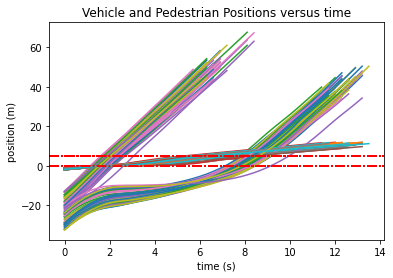

In [9]:
#Positions des agents
t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

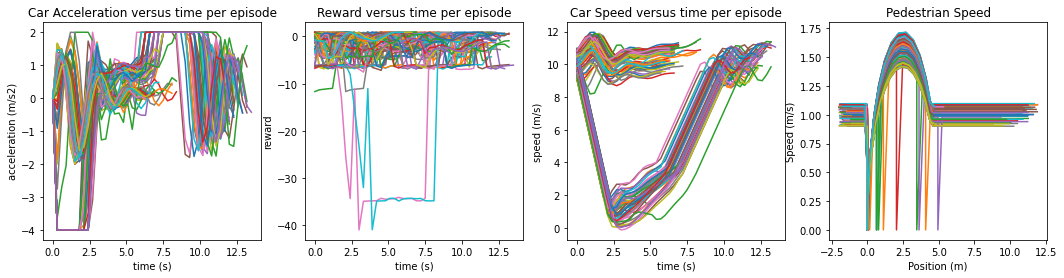

In [10]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1


In [11]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=20
size_cross=40

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1

    if(choice):
        min_l=min(t-t_init,size_cross)
        return_speed=np.array(ep_speed_car[t_init:t_init+min_l])
        return_acc=np.array(states[t_init:t_init+min_l,0])
        if(min_l<size_cross):
            return_speed=np.append(return_speed,[ep_speed_car[t-1]]*(size_cross-t+t_init))
            return_acc=np.append(return_acc,[states[t-1,0]]*(size_cross-t+t_init))
        cross_speed.append(return_speed)
        cross_acc.append(return_acc)
    else:
        min_l=min(t-t_init,size_wait)
        return_speed=np.array(ep_speed_car[t_init:t_init+min_l])
        return_acc=np.array(states[t_init:t_init+min_l,0])
        if(min_l<size_wait):
            return_speed=np.append(return_speed,[ep_speed_car[t-1]]*(size_wait-t+t_init))
            return_acc=np.append(return_acc,[states[t-1,0]]*(size_wait-t+t_init))
        wait_speed.append(return_speed)
        wait_acc.append(return_acc)
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

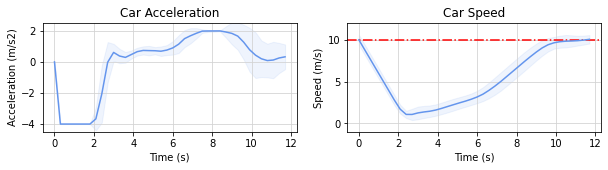

In [12]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_cross_ppo12.pdf")


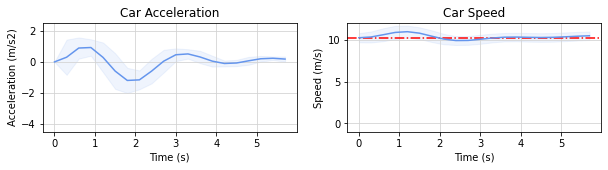

In [13]:
x1=[0.3*i for i in range(size_wait)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')
fig.savefig("PDF_results/car_wait_ppo12.pdf")

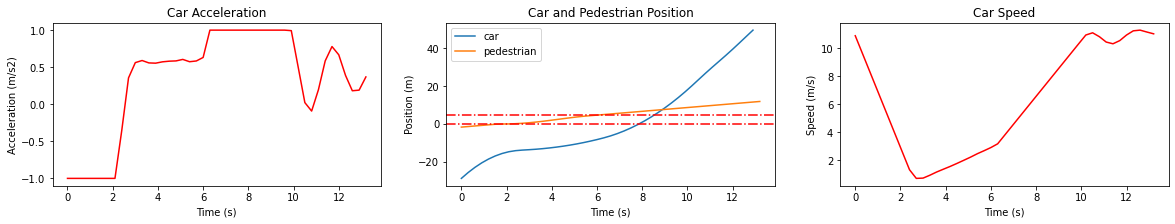

In [18]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode
#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-1.1,1.1)
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')
t+=1

In [19]:
def estimation_value(x1,x2,x3,y1,y3):
    a=(y3-y1)/(x3-x1)
    b=(y1*x3 - y3*x1)/(x3-x1)
    return a*x2+b

def extract_estimations(positions, parameter, start_position, end_position, step_pos):
    size_position=int((end_position-start_position)/step_pos)
    length=len(positions)
    array_cross=np.array([0.0]*size_position)
    i_step=0
    i_pos=start_position
    i=0
    while(i_pos<positions[i_step]):
        array_cross[i]=parameter[i_step]
        i=i+1
        i_pos=i_pos+0.5
    while(i_step<length and i<size_position):
        while( i_step+1<length and i_pos>positions[i_step]):
            i_step=i_step+1
        array_cross[i]=estimation_value(positions[i_step-1],i_pos,positions[i_step],parameter[i_step-1],parameter[i_step])
        i=i+1
        i_pos=i_pos+0.5
    while(i<size_position):
        array_cross[i]=parameter[i_step-1]
        i=i+1
    return array_cross

In [20]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
start_position=-32.5
end_position=32.5
while t+1<len(ep_time):
    
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
        
    if(choice):
        return_speed=extract_estimations(ep_pos_car[t_init:t], ep_speed_car[t_init:t],start_position,end_position,0.5)
        return_acc=extract_estimations(ep_pos_car[t_init:t], ep_action[t_init:t],start_position,end_position,0.5)
        cross_speed.append(return_speed)
        cross_acc.append(return_acc)
        
    else:
        return_speed=extract_estimations(ep_pos_car[t_init:t], ep_speed_car[t_init:t],start_position,end_position,0.5)
        return_acc=extract_estimations(ep_pos_car[t_init:t], ep_action[t_init:t],start_position,end_position,0.5)
        wait_speed.append(return_speed)
        wait_acc.append(return_acc)
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

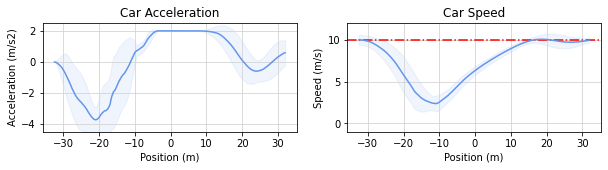

In [21]:
size_position=int((end_position-start_position)/0.5)
x1=[i*0.5+start_position for i in range(0,size_position)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Position (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')

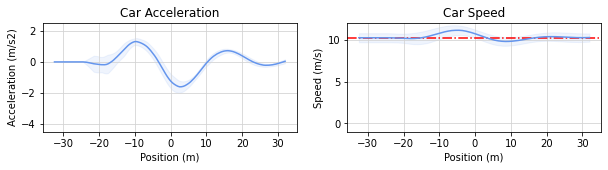

In [22]:
x1=[i*0.5+start_position for i in range(0,size_position)]
mean_speed=np.mean(wait_speed,axis=0)
std_speed=np.std(wait_speed,axis=0)
mean_acc=np.mean(wait_acc,axis=0)
std_acc=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Position (m)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Position (m)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')

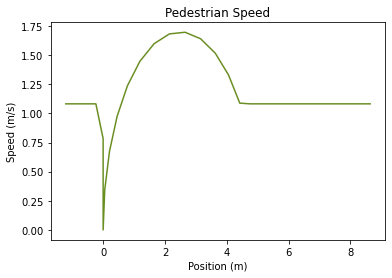

In [15]:
plt.title('Pedestrian Speed')
plt.xlabel("Position (m)")
plt.ylabel("Speed (m/s)")
plt.plot(states[t_init:t-10,4],states[t_init:t-10,3], color='olivedrab')
#plt.savefig("PDF_results/ped_speed.pdf")